In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the .npy file
# loaded_array = np.load('dataset_newsim_2x500x500_crop100.npy')
loaded_array = np.load('dataset_oldsim_2x100x500_crop9087.npy')
train_data = loaded_array[:700,:1].transpose(0,2,3,1)
test_data = loaded_array[800:1000,:1].transpose(0,2,3,1)
train_data = (train_data - np.mean(train_data, axis=(-3,-2), keepdims=True) )/ (np.std(train_data, axis=(-3,-2), keepdims=True) +1)
test_data = (test_data - np.mean(test_data, axis=(-3,-2), keepdims=True) )/ (np.std(test_data, axis=(-3,-2), keepdims=True) +1)
# train_data = (train_data - np.min(train_data, axis=(-3,-2), keepdims=True)) / (np.max(train_data, axis=(-3,-2), keepdims=True) - np.min(train_data, axis=(-2,-3), keepdims=True))
# Now, `loaded_array` is a numpy array containing the data from the .npy file


In [70]:
import tensorflow_datasets as tfds

# Load the dataset
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-13 11:32:57.070048: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|██████████| 5/5 [00:03<00:00,  1.63 file/s]

Dataset mnist downloaded and prepared to /Users/mo2016/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [49]:

# Target new shape parameters
target_height = 128
target_width = 512

# Compute padding sizes
pad_height = (target_height - train_data.shape[1]) // 2
pad_width = (target_width - train_data.shape[2]) // 2

# Pad the array
train_data = np.pad(train_data, pad_width=((0,0), (pad_height, pad_height), (pad_width, pad_width), (0,0)), mode='constant', constant_values=0)

train_data.shape


(700, 128, 512, 1)

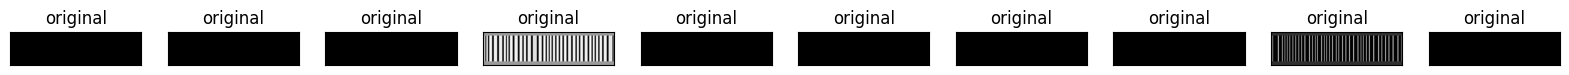

In [50]:
n = 10
plt.figure(figsize=(20, 20))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(train_data[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

#   # display reconstruction
#   ax = plt.subplot(2, n, i + 1 + n)
#   plt.imshow(decoded_imgs[i])
#   plt.title("reconstructed")
#   plt.gray()
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)
plt.show()

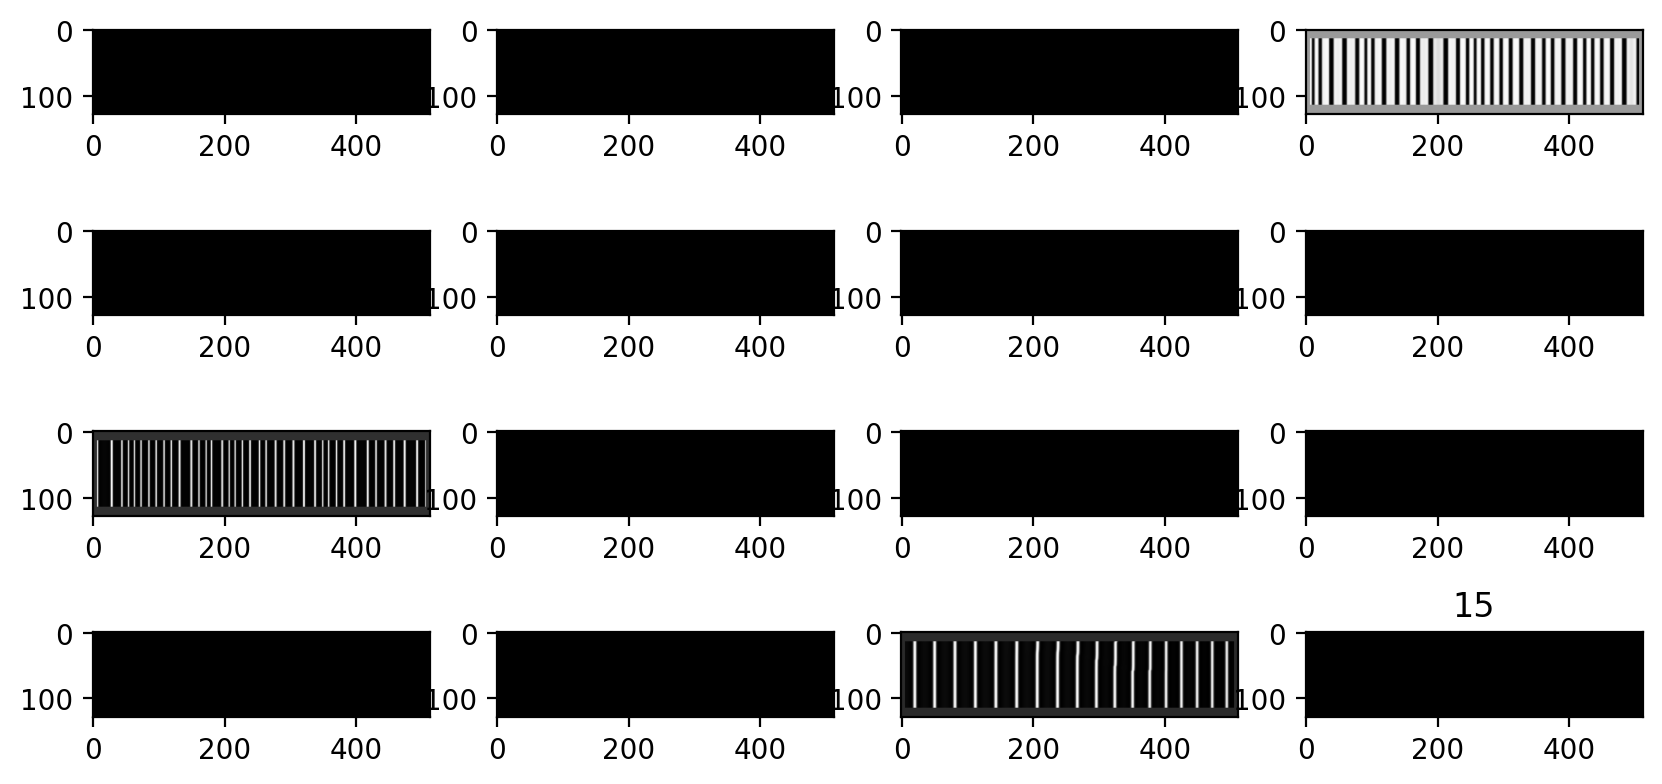

In [51]:
import tensorflow as tf

n = 16
fig, axs = plt.subplots(4, 4, figsize=(10, 5), dpi=200)
for i in range(n):
    ax = axs.flatten()[i]
    plt.title(i)
    ax.imshow(tf.squeeze(train_data[i]))
    plt.gray()


# n = 2

# fig, axs = plt.subplots(4, 4, figsize=(10, 5), dpi=200)
# for i in range(n):
#     ax = axs.flatten()[i]
#     plt.title(i)
#     ax.imshow(tf.squeeze(test_data[i]))
#     plt.gray()

In [52]:
noise_factor = 0.2
x_train_noisy = train_data + noise_factor * tf.random.normal(shape=train_data.shape) 
x_test_noisy = test_data + noise_factor * tf.random.normal(shape=test_data.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [53]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_data))

In [54]:
BATCH_SIZE = 4 
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      # layers.Conv2D(8, (5, 5), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(5)])

    self.decoder = tf.keras.Sequential([
      layers.Input(shape=(5,)),
      layers.Dense(7*7*8, activation='relu'),
      layers.Reshape((7, 7, 16)),
      # layers.Conv2DTranspose(8, kernel_size=5, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

ValueError: Exception encountered when calling layer "reshape_18" (type Reshape).

total size of new array must be unchanged, input_shape = [392], output_shape = [7, 7, 16]

Call arguments received by layer "reshape_18" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 392), dtype=float32)

In [103]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

In [104]:
autoencoder.fit(ds_train,
                epochs=2,
                shuffle=True,
                
                )

Epoch 1/2


ValueError: in user code:

    File "/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/bt/1cqt3cks1sl9cz4dfwlyxhpm0000gn/T/__autograph_generated_filelc_s1969.py", line 10, in tf__call
        encoded = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(x),), None, fscope)

    ValueError: Exception encountered when calling layer 'denoise_17' (type Denoise).
    
    in user code:
    
        File "/var/folders/bt/1cqt3cks1sl9cz4dfwlyxhpm0000gn/T/ipykernel_76415/910867979.py", line 32, in call  *
            encoded = self.encoder(x)
        File "/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Exception encountered when calling layer 'sequential_34' (type Sequential).
        
        Input 0 of layer "dense_34" is incompatible with the layer: expected axis -1 of input shape to have value 784, but received input with shape (28, 112)
        
        Call arguments received by layer 'sequential_34' (type Sequential):
          • inputs=tf.Tensor(shape=(28, 28, 1), dtype=uint8)
          • training=True
          • mask=None
    
    
    Call arguments received by layer 'denoise_17' (type Denoise):
      • x=tf.Tensor(shape=(28, 28, 1), dtype=uint8)


In [61]:
z = autoencoder.encoder(train_data)
z.shape

TensorShape([700, 20])

KeyboardInterrupt: 

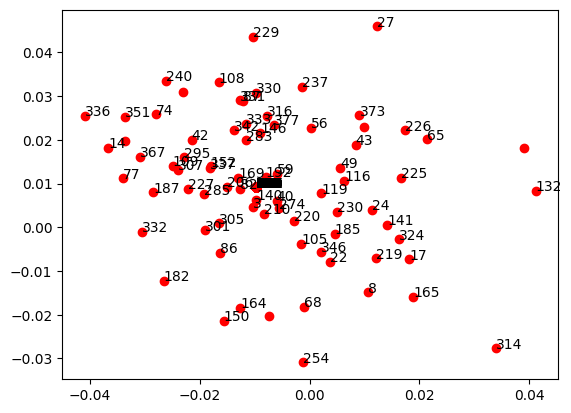

In [62]:
plt.scatter(z[:,0], z[:,1], c = 'r')
for index, z in enumerate(z):
    plt.text(z[0], z[1], str(index))

plt.show()

IndexError: index 16 is out of bounds for axis 0 with size 16

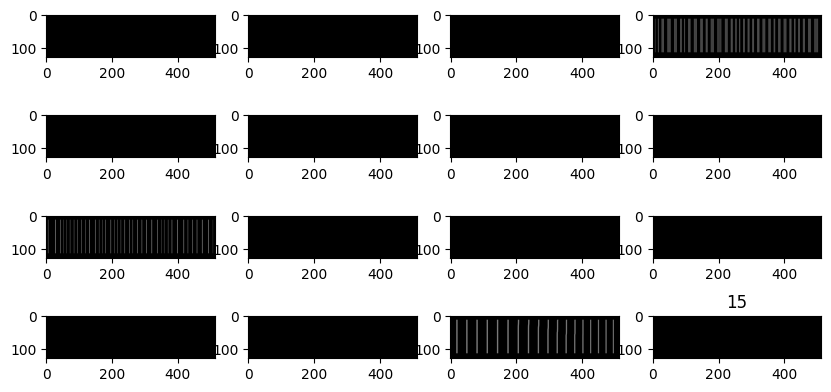

In [63]:
n = 78
fig, axs = plt.subplots(4, 4, figsize=(10, 5))
for i in range(n):
    ax = axs.flatten()[i]
    plt.title(i)
    ax.imshow(tf.squeeze(train_data[i]), vmin=0, vmax=train_data.max())
    plt.gray()
    
fig, axs = plt.subplots(4, 4, figsize=(10, 5))
axs = axs.flatten()
for i in range(n):
    ax = axs[i]
    plt.title(i)
    ax.imshow(tf.squeeze(train_data[i]), vmin=0, vmax=1)
    plt.gray()
plt.show()


-1.2983961


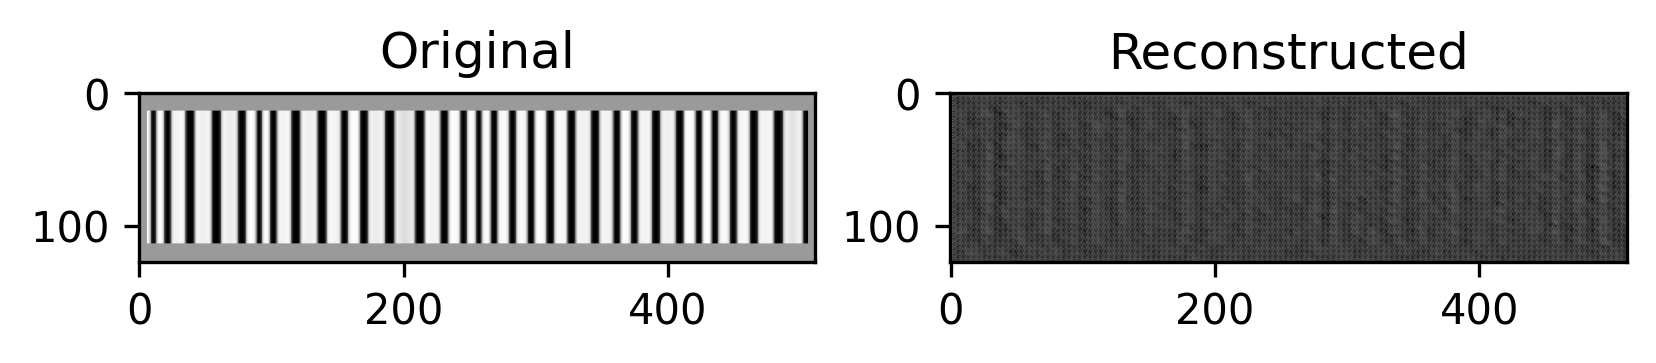

<tf.Tensor: shape=(128, 512, 1), dtype=float32, numpy=
array([[[ 3.21848580e-04],
        [ 2.85767775e-04],
        [ 6.58633653e-05],
        ...,
        [ 3.99874960e-04],
        [ 5.87805698e-05],
        [ 6.06499787e-04]],

       [[-6.02354703e-05],
        [ 1.98295907e-04],
        [ 3.36746161e-05],
        ...,
        [ 1.16795505e-04],
        [ 3.16414516e-05],
        [-7.00818491e-05]],

       [[ 3.42400366e-04],
        [ 2.66864372e-05],
        [ 2.43205286e-05],
        ...,
        [ 9.47559602e-05],
        [ 8.92842654e-05],
        [ 3.44899629e-04]],

       ...,

       [[-1.68046739e-04],
        [ 2.58274027e-04],
        [-4.41103475e-06],
        ...,
        [ 8.74372199e-06],
        [-5.96348837e-05],
        [-5.64765360e-05]],

       [[ 3.35859571e-04],
        [-6.45513646e-05],
        [-6.77004573e-05],
        ...,
        [-3.04308196e-05],
        [-3.56364471e-05],
        [ 2.97628634e-04]],

       [[ 1.93965287e-04],
        [ 2.22505041

In [68]:
x = train_data[3][None]
y = autoencoder(x)[0]
print(np.sum(y))

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

ax1.imshow(tf.squeeze(x))
ax1.set_title('Original')

ax2.imshow(tf.squeeze(y))
ax2.set_title('Reconstructed')

plt.show()
y
